## Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras
### Adapted from:
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [176]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as mt

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

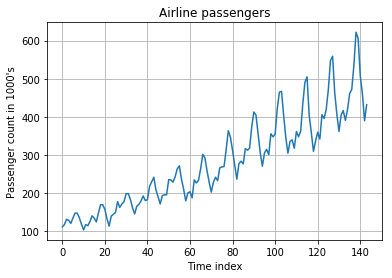

In [177]:
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

plt.plot(dataset)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.show()

## Long Short-Term Memory Network
- The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.
- As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.
- Instead of neurons, LSTM networks have memory blocks that are connected through layers.
- A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.
- There are three types of gates within a unit:
    - **Forget Gate**: conditionally decides what information to throw away from the block.
    - **Input Gate**: conditionally decides which values from the input to update the memory state.
    - **Output Gate**: conditionally decides what to output based on input and the memory of the block.
- Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.
- You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## LSTM Network for Regression
- We can phrase the problem as a regression problem.
- That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?
- We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.
- **LSTMs are sensitive to the scale of the input data**, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [178]:
# Fix random seed for reproducibility
np.random.seed(7)

# Load the data
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

print "Pre-Normalization:\n", dataset[0:5]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

print "\nPost-Normalization:\n", dataset[0:5]

Pre-Normalization:
[[ 112.]
 [ 118.]
 [ 132.]
 [ 129.]
 [ 121.]]

Post-Normalization:
[[ 0.01544401]
 [ 0.02702703]
 [ 0.05405405]
 [ 0.04826255]
 [ 0.03281853]]


- After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.
- With time series data, **the sequence of values is important**. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.
    - Ref.: TimeSeriesExperimentation/04_BacktestMachineLearningModelsForTimeSeriesForecasting

In [179]:
# Split into training and testing sets
trainSizeRatio = 0.67

trainSize = int(len(dataset) * trainSizeRatio)
testSize = len(dataset) - trainSize

train, test = dataset[0:trainSize, :], dataset[trainSize:len(dataset), :]

print "Dataset size:  ", len(dataset)
print "Training size: ", len(train)
print "Testing size:  ", len(test)

Dataset size:   144
Training size:  96
Testing size:   48


- Now we can define a function to create a new dataset, as described above.
- The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.
- This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
- It can be configured, and we will by constructing a differently shaped dataset in the next section.
- Ref.: TimeSeriesExperimentation/01_TimeSeriesToSupervisedLearningProblem

In [180]:
# Convert an array of values into a dataset matrix
# i.e. convert a Time Series problem into a Supervised problem
def createDataset(dataset, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack - 1):
        a = dataset[i:(i + lookBack), 0]
        dataX.append(a)
        dataY.append(dataset[i + lookBack, 0])

    return np.array(dataX), np.array(dataY)

In [181]:
# Reshape into X=t and Y=t+1 --> Supervised problem
lookBack = 1
trainX, trainY = createDataset(train, lookBack)
testX, testY = createDataset(test, lookBack)

print "Shifted training Data:"
print "X: ", trainX[0:5, 0]
print "Y: ", trainY[0:5]

print "\nShifted testing Data:"
print "X: ", testX[0:5, 0]
print "Y: ", testY[0:5]

Shifted training Data:
X:  [ 0.01544401  0.02702703  0.05405405  0.04826255  0.03281853]
Y:  [ 0.02702703  0.05405405  0.04826255  0.03281853  0.05984557]

Shifted testing Data:
X:  [ 0.40733591  0.3803089   0.48648646  0.47104248  0.48455599]
Y:  [ 0.3803089   0.48648646  0.47104248  0.48455599  0.61389959]


- The LSTM network expects the input data (X) to be provided with a specific array structure in the form of:
    - [samples, time steps, features].
- Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [182]:
# Reshape input to be [samples, time steps, features]

print "Before: trainX.shape = ", trainX.shape
print "Before: testX.shape  = ", testX.shape

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print "\nAfter: trainX.shape  = ", trainX.shape
print "After: testX.shape   = ", testX.shape

Before: trainX.shape =  (94, 1)
Before: testX.shape  =  (46, 1)

After: trainX.shape  =  (94, 1, 1)
After: testX.shape   =  (46, 1, 1)


- We are now ready to design and fit our LSTM network for this problem.
- The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [183]:
# Create and fit the LSTM network
model = Sequential()

model.add(LSTM(4, input_shape=(1, lookBack)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

modelHistory = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

plot_model(model, to_file='model.png', show_shapes=True)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0145
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

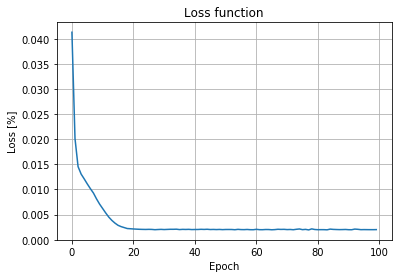

In [184]:
# Visualize LSTM network architecture
plot_model(model, to_file='model_1.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(modelHistory.history['loss'])
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

- Once the model is fit, we can estimate the performance of the model on the training and testing datasets. This will give us a point of comparison for new models.
- Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [185]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print 'Train Score: %.2f RMSE' % (trainScore)

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print 'Test Score:  %.2f RMSE' % (testScore)

Train Score: 22.92 RMSE
Test Score:  47.53 RMSE


- We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 48 passengers (in thousands) on the test dataset.
- Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.
- Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

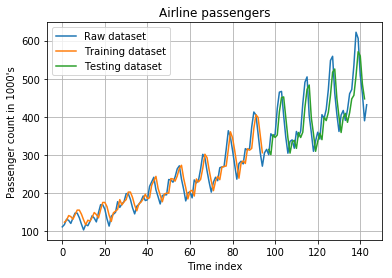

In [186]:
# Shift training predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredictInverted) + lookBack, :] = trainPredictInverted

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInverted) + (lookBack * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()

## LSTM for Regression Using the Window Method
- We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.
- This is called a **window**, and the size of the window is a parameter that can be tuned for each problem.
- For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.
- When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.
- The createDataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the lookBack argument from 1 to 3.
- We can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned

In [187]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [188]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
modelHistory = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0515
Epoch 2/100
 - 0s - loss: 0.0243
Epoch 3/100
 - 0s - loss: 0.0160
Epoch 4/100
 - 0s - loss: 0.0137
Epoch 5/100
 - 0s - loss: 0.0123
Epoch 6/100
 - 0s - loss: 0.0110
Epoch 7/100
 - 0s - loss: 0.0099
Epoch 8/100
 - 0s - loss: 0.0087
Epoch 9/100
 - 0s - loss: 0.0077
Epoch 10/100
 - 0s - loss: 0.0068
Epoch 11/100
 - 0s - loss: 0.0059
Epoch 12/100
 - 0s - loss: 0.0054
Epoch 13/100
 - 0s - loss: 0.0049
Epoch 14/100
 - 0s - loss: 0.0045
Epoch 15/100
 - 0s - loss: 0.0042
Epoch 16/100
 - 0s - loss: 0.0040
Epoch 17/100
 - 0s - loss: 0.0039
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0037
Epoch 20/100
 - 0s - loss: 0.0037
Epoch 21/100
 - 0s - loss: 0.0036
Epoch 22/100
 - 0s - loss: 0.0036
Epoch 23/100
 - 0s - loss: 0.0036
Epoch 24/100
 - 0s - loss: 0.0036
Epoch 25/100
 - 0s - loss: 0.0035
Epoch 26/100
 - 0s - loss: 0.0035
Epoch 27/100
 - 0s - loss: 0.0033
Epoch 28/100
 - 0s - loss: 0.0033
Epoch 29/100
 - 0s - loss: 0.0033
Epoch 30/100
 - 0s - lo

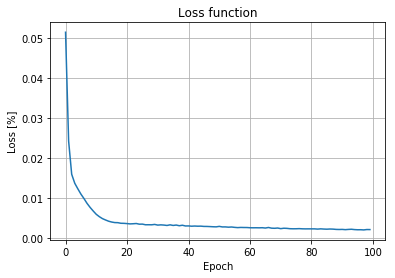

In [189]:
# Visualize LSTM network architecture
plot_model(model, to_file='model_2.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(modelHistory.history['loss'])
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

In [190]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.77 RMSE
Test Score: 60.26 RMSE


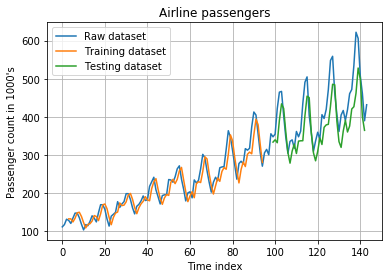

In [191]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictInverted) + look_back, :] = trainPredictInverted

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInverted) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()

## LSTM for Regression with Time Steps
- You may have noticed that the data preparation for the LSTM network includes time steps.
- Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.
- Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.
- Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.
- We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1.
- We can see that the results are slightly better than previous example, although the structure of the input data makes a lot more sense.

In [192]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [193]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

modelHistory = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0454
Epoch 2/100
 - 0s - loss: 0.0181
Epoch 3/100
 - 0s - loss: 0.0134
Epoch 4/100
 - 0s - loss: 0.0116
Epoch 5/100
 - 0s - loss: 0.0102
Epoch 6/100
 - 0s - loss: 0.0086
Epoch 7/100
 - 0s - loss: 0.0074
Epoch 8/100
 - 0s - loss: 0.0064
Epoch 9/100
 - 0s - loss: 0.0054
Epoch 10/100
 - 0s - loss: 0.0049
Epoch 11/100
 - 0s - loss: 0.0046
Epoch 12/100
 - 0s - loss: 0.0042
Epoch 13/100
 - 0s - loss: 0.0040
Epoch 14/100
 - 0s - loss: 0.0041
Epoch 15/100
 - 0s - loss: 0.0039
Epoch 16/100
 - 0s - loss: 0.0040
Epoch 17/100
 - 0s - loss: 0.0038
Epoch 18/100
 - 0s - loss: 0.0038
Epoch 19/100
 - 0s - loss: 0.0039
Epoch 20/100
 - 0s - loss: 0.0038
Epoch 21/100
 - 0s - loss: 0.0038
Epoch 22/100
 - 0s - loss: 0.0039
Epoch 23/100
 - 0s - loss: 0.0038
Epoch 24/100
 - 0s - loss: 0.0037
Epoch 25/100
 - 0s - loss: 0.0037
Epoch 26/100
 - 0s - loss: 0.0038
Epoch 27/100
 - 0s - loss: 0.0037
Epoch 28/100
 - 0s - loss: 0.0037
Epoch 29/100
 - 0s - loss: 0.0037
Epoch 30/100
 - 0s - lo

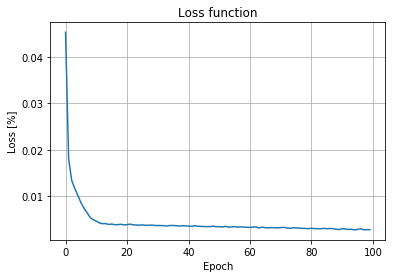

In [194]:
# Visualize LSTM network architecture
plot_model(model, to_file='model_2.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(modelHistory.history['loss'])
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

In [195]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28.27 RMSE
Test Score: 69.31 RMSE


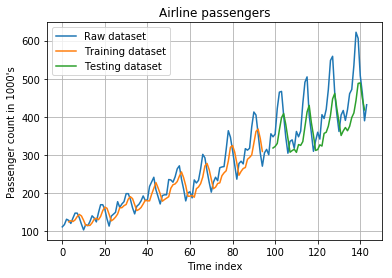

In [196]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictInverted) + look_back, :] = trainPredictInverted

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInverted) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()

## LSTM with Memory Between Batches
- The LSTM network has memory, which is capable of remembering across long sequences.
- Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().
- We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.
- It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states().

    - `for i in range(100):
        model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()`
        
- Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

    - `model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))`

- This same batch size must then be used later when evaluating the model and making predictions. For example:
    - `model.predict(trainX, batch_size=batch_size)`
- We can adapt the previous time step example to use a stateful LSTM.
- We do see that results are worse. The model may need more modules and may need to be trained for more epochs to internalize the structure of the problem.

In [197]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [198]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss = []

for i in range(100):
    modelHistory = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    loss.extend(modelHistory.history['loss'])

Epoch 1/1
 - 1s - loss: 0.0098
Epoch 1/1
 - 0s - loss: 0.0133
Epoch 1/1
 - 0s - loss: 0.0091
Epoch 1/1
 - 0s - loss: 0.0071
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0051
Epoch 1/1
 - 0s - loss: 0.0049
Epoch 1/1
 - 0s - loss: 0.0049
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/

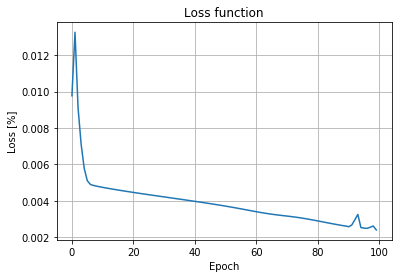

In [199]:
# Visualize LSTM network architecture
plot_model(model, to_file='model_3.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(loss)
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

In [200]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 30.65 RMSE
Test Score: 133.55 RMSE


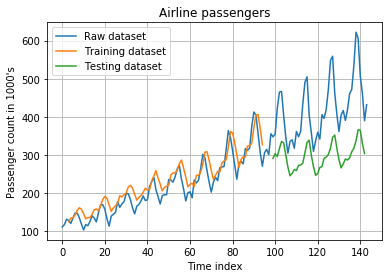

In [201]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictInverted) + look_back, :] = trainPredictInverted

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInverted) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()

## Stacked LSTMs with Memory Between Batches
- Finally, we will take a look at one of the big benefits of LSTMs: the fact that they can be successfully trained when stacked into deep network architectures.
- LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True.
- We can extend the stateful LSTM in the previous section to have two layers, as follows:
    - `model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))`
- The predictions on the test dataset are again worse. This is more evidence to suggest the need for additional training epochs.

In [202]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = createDataset(train, look_back)
testX, testY = createDataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [203]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

loss = []

for i in range(100):
    modelHistory = model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    
    loss.extend(modelHistory.history['loss'])

Epoch 1/1
 - 2s - loss: 0.0064
Epoch 1/1
 - 0s - loss: 0.0289
Epoch 1/1
 - 0s - loss: 0.0196
Epoch 1/1
 - 0s - loss: 0.0156
Epoch 1/1
 - 0s - loss: 0.0110
Epoch 1/1
 - 0s - loss: 0.0076
Epoch 1/1
 - 0s - loss: 0.0068
Epoch 1/1
 - 0s - loss: 0.0064
Epoch 1/1
 - 0s - loss: 0.0062
Epoch 1/1
 - 0s - loss: 0.0060
Epoch 1/1
 - 0s - loss: 0.0059
Epoch 1/1
 - 0s - loss: 0.0059
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0059
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/1
 - 0s - loss: 0.0058
Epoch 1/

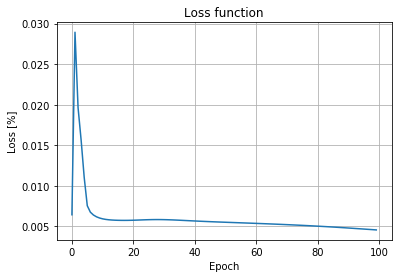

In [204]:
# Visualize LSTM network architecture
plot_model(model, to_file='model_3.png', show_shapes=True)

# Plot loss variation with trianing epochs
plt.plot(loss)
plt.grid()
plt.title('Loss function')
plt.xlabel('Epoch')
plt.ylabel('Loss [%]')
plt.show()

In [205]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredictInverted = scaler.inverse_transform(trainPredict)
trainYInverted = scaler.inverse_transform([trainY])

testPredictInverted = scaler.inverse_transform(testPredict)
testYInverted = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = mt.sqrt(mean_squared_error(trainYInverted[0], trainPredictInverted[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mt.sqrt(mean_squared_error(testYInverted[0], testPredictInverted[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 34.30 RMSE
Test Score: 86.38 RMSE


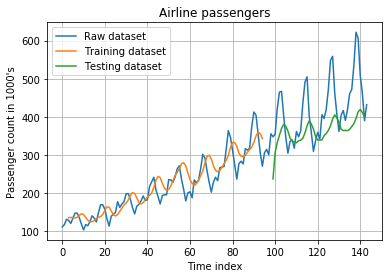

In [206]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictInverted) + look_back, :] = trainPredictInverted

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictInverted) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredictInverted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid()
plt.title('Airline passengers')
plt.xlabel('Time index')
plt.ylabel('Passenger count in 1000\'s')
plt.legend(['Raw dataset', 'Training dataset', 'Testing dataset'])
plt.show()